In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import librosa

In [ ]:
#import sys and pathlib for adding project root to path
import sys
from pathlib import Path

In [ ]:
#this is from our module data_augmentation.py
from data_augmentation import frequency_masking, convert_to_spectrogram, load_to_float32, normalize_audio, fade_in_out

In [ ]:
# add project module path for local imports
module_path = os.path.join(project_root, 'databass', 'preprocess')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
module_path

'/home/edgar/code/Arkyed/08-Project/databass-code/DataBass/databass/preprocess'

In [ ]:
# now import using the local module path
from spectrograms import generate_mel_spectrogram, plot_mel_spectrogram

In [ ]:
project_root = Path().resolve().parents[2]
print(f"Project root: {project_root}")
project_root

Project root: /home/edgar/code/Arkyed/08-Project/databass-code/DataBass


PosixPath('/home/edgar/code/Arkyed/08-Project/databass-code/DataBass')

0.36584473


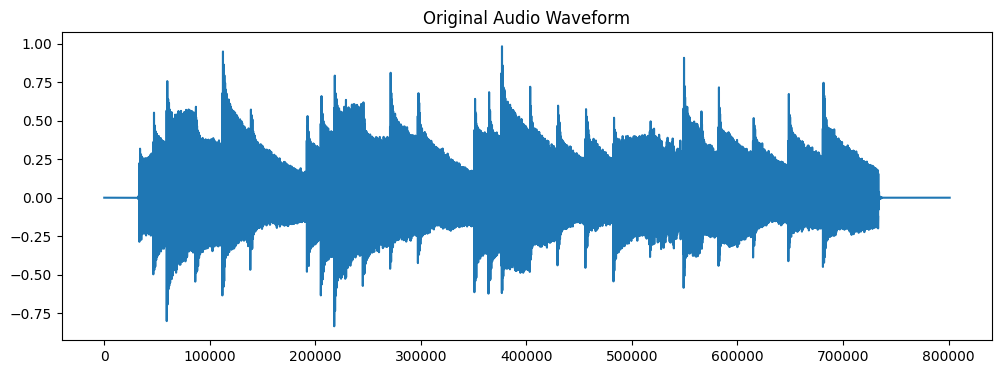

In [ ]:
file_path = os.path.join(project_root, 'notebooks', 'Edgar', 'HappyBDay.wav')

y , sr = librosa.load(file_path, sr=None)
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title('Original Audio Waveform')
print(y[50000])

Text(0.5, 1.0, 'Normalized Audio Waveform')

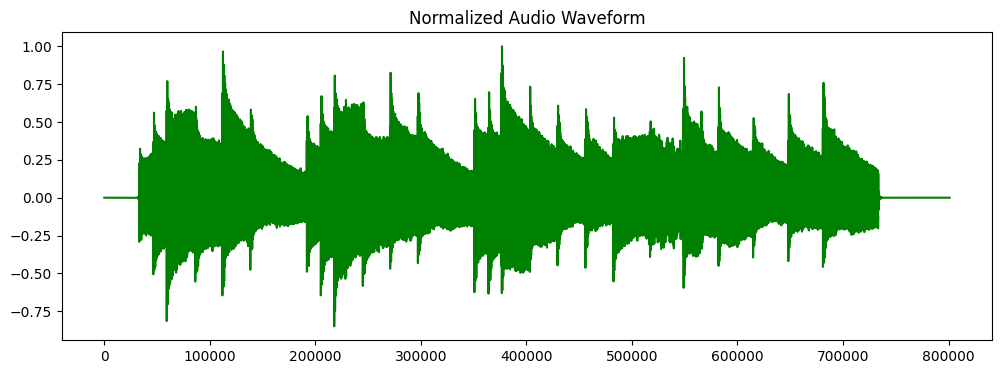

In [ ]:
#let's normalize the audio

max_val = np.max(np.abs(y))
if max_val == 0:
    pass
normalized_audio = y / max_val

plt.figure(figsize=(12, 4))
plt.plot(normalized_audio,c='green')
plt.title('Normalized Audio Waveform')

Text(0.5, 1.0, 'Noisy Audio Waveform')

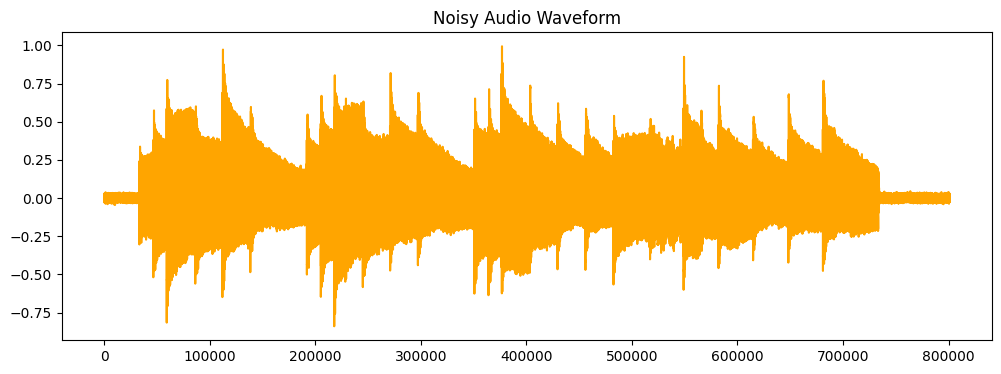

In [ ]:
#let's try adding noise augmentation
noise_factor = 0.01
noisy_audio = y + noise_factor * np.random.normal(size=y.shape)

plt.figure(figsize=(12, 4))
plt.plot(noisy_audio,c='orange')
plt.title('Noisy Audio Waveform')

Text(0, 0.5, 'Amplitude')

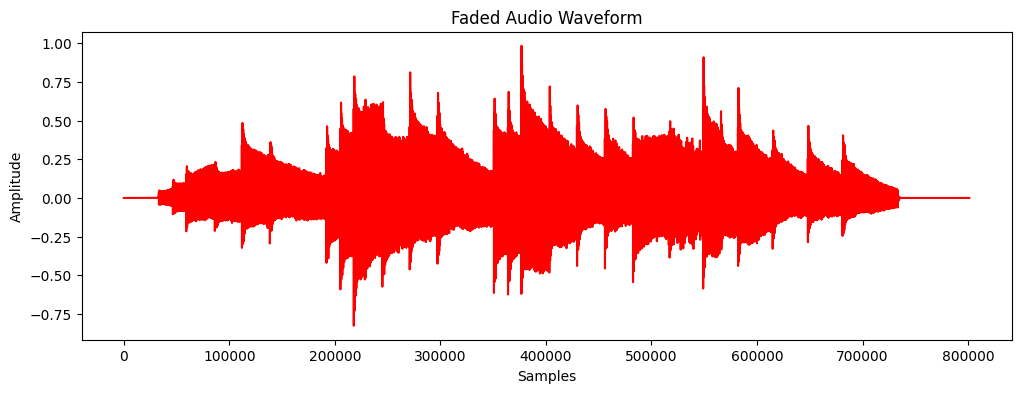

In [ ]:
#let's try the fade in and fade out augmentation

fade_duration = 1 # in sec

num_fade_samples = int(fade_duration * sr)
max_fade = (len(y) // 2) if y.ndim == 1 else (y.shape[0] // 2)
num_fade_samples = max(1, min(num_fade_samples, max_fade))

# create fade in/out ramps (1D)
fade_in_ramp = np.linspace(0.0, 1.0, num_fade_samples, dtype=y.dtype)
fade_out_ramp = np.linspace(1.0, 0.0, num_fade_samples, dtype=y.dtype)

# apply fades depending on mono (1D) vs stereo/multi-channel (2D)
if y.ndim == 1:
    faded = y.copy()
    faded[:num_fade_samples] = faded[:num_fade_samples] * fade_in_ramp
    faded[-num_fade_samples:] = faded[-num_fade_samples:] * fade_out_ramp
else:
    faded = y.copy()
    faded[:num_fade_samples, :] = faded[:num_fade_samples, :] * fade_in_ramp[:, None]
    faded[-num_fade_samples:, :] = faded[-num_fade_samples:, :] * fade_out_ramp[:, None]

plt.figure(figsize=(12, 4))
plt.plot(faded,c='red')
plt.title('Faded Audio Waveform')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

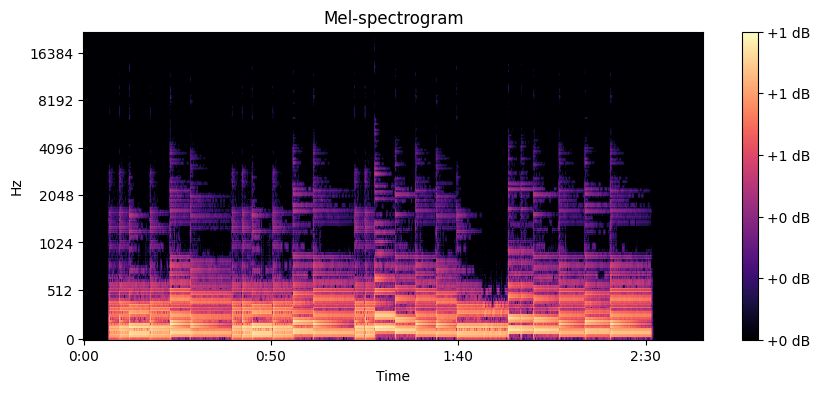

In [ ]:
#let's use some spectrogram augmentation
spectrogram = generate_mel_spectrogram(y, sr, fmax=8000, n_fft=2048,
                             normalize='minmax', target_shape=(256,256), duration=2.0)

plot_mel_spectrogram(spectrogram, sr, y=y, target_shape=(256,256))

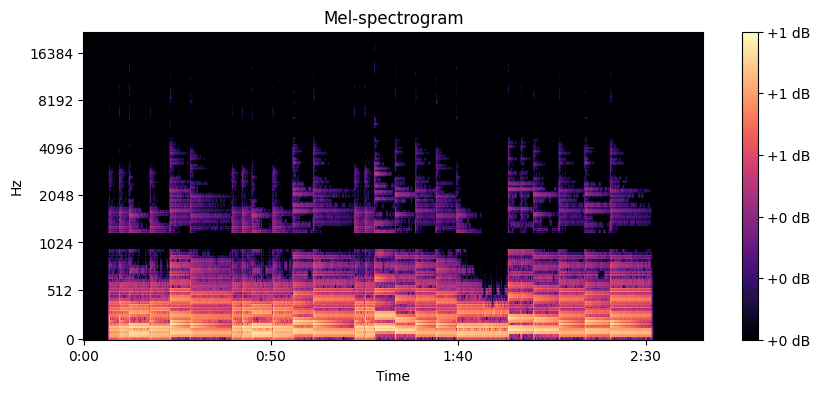

(256, 2323)

In [ ]:
# let's add frequency masking
masked = spectrogram.copy()
num_bins = masked.shape[0]
freq_mask_param = np.random.randint(8, 25)  # random frequency mask parameter between 5 and 25
num_masks = 2
for _ in range(num_masks):
    #horizontal mask
    f = np.random.randint(1, freq_mask_param + 1)
    # ensure f0 + f does not exceed num_bins
    f0 = np.random.randint(0, max(1, num_bins - f))
    # apply the mask
    masked[f0:f0 + f, :] = 0.0

plot_mel_spectrogram(masked, sr, y=y, target_shape=(256,256))
masked.shape

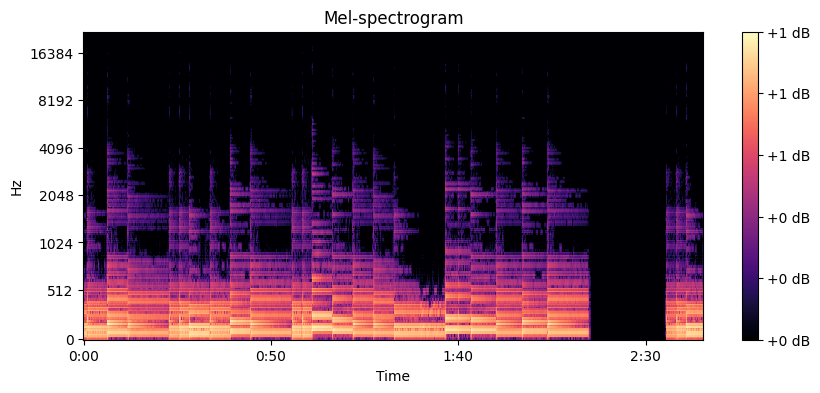

In [ ]:
# let's try shifting time of the audio
shift_max = 5  # maximum shift as a fraction of total length
shift = np.random.randint(int(sr * -shift_max), int(sr * shift_max))

shifted_audio = np.roll(y, shift)
shift_mel = generate_mel_spectrogram(shifted_audio, sr, fmax=8000, n_fft=2048,
                             normalize='minmax', target_shape=(256,256), duration=2.0)
plot_mel_spectrogram(shift_mel, sr, y=shifted_audio, target_shape=(256,256))